In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

import numpy as np
import os
import matplotlib.pyplot as plt
import cPickle as pickle
import gzip
from photutils import CircularAnnulus
from photutils import CircularAperture
from photutils import aperture_photometry
from astropy.visualization import hist
from stackocat import QSOcat

from utils import *

In [2]:
# SPIRE channels
lambdas = [250, 350, 500]
psf     = {250:17.8, 350:24.0, 500:35.2} # in arcsec 
factor  = {250:469./36., 350:831./64., 500:1804./144.} # Jy/beam -> Jy/pixel 
reso    = {250:6., 350:8., 500:12.} # in arcsec 
positions = {250: (25.5, 25.5), 350: (19.5,19.5), 500:(13.5,13.5), 90:(20,20)}
boxsize = {250:51, 350:39, 500:27, 90:40}

# H-ATLAS patches
patches = ['G9', 'G12', 'G15']#, 'NGP', 'SGP']

# Results folder
results_folder = 'results_filt_H-ATLAS_W4'

zbins = [(1.,5.)]#[(1.,2.15), (2.15,2.50),(2.50,5.0)]

rmax = 9

extras_names = [
    'Z',
    'JMAG',			 # J magnitude 2MASS
    'ERR_JMAG',		 # Error J magnitude 2MASS
    'HMAG',			 # H magnitude 2MASS
    'ERR_HMAG',		 # Error H magnitude 2MASS
    'KMAG',			 # K magnitude 2MASS
    'ERR_KMAG',		 # Error K magnitude 2MASS
    'W1MAG',		 # w1 magnitude WISE
    'ERR_W1MAG',     # Error w1 magnitude WISE
    'W2MAG',		 # w2 magnitude WISE
    'ERR_W2MAG',     # Error w1 magnitude WISE
    'W3MAG',		 # w3 magnitude WISE
    'ERR_W3MAG',     # Error w1 magnitude WISE
    'W4MAG',		 # w4 magnitude WISE
    'ERR_W4MAG',     # Error w1 magnitude WISE
    'CC_FLAGS',     # WISE contamination and confusion flag
    'UKIDSS_MATCHED',# UKIDSS matched
    'YFLUX',         # Y-band flux density [Jy]
    'YFLUX_ERR',     # Error in Y-band density flux [Jy]
    'JFLUX',         # J-band flux density [Jy]
    'JFLUX_ERR',     # Error in J-band density flux [Jy]
    'HFLUX',         # H-band flux density [Jy]
    'HFLUX_ERR',     # Error in H-band density flux [Jy]
    'KFLUX',         # K-band flux density [Jy]
    'KFLUX_ERR',     # Error in K-band density flux [Jy]
    'PSFFLUX_U',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'PSFFLUX_G',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'PSFFLUX_R',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'PSFFLUX_I',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'PSFFLUX_Z',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'IVAR_PSFFLUX_U',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_G',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_R',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_I',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_Z',  # Inverse variance of ugriz fluxes
    'EXTINCTION_U',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_G',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_R',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_I',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_Z',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_RECAL_U', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'EXTINCTION_RECAL_G', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'EXTINCTION_RECAL_R', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'EXTINCTION_RECAL_I', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'EXTINCTION_RECAL_Z', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'FLUX02_12KEV',     # Total flux (0.2 - 12 keV) XMM [erg/cm^2/s]
    'ERR_FLUX02_12KEV', # Error in total flux (0.2 - 12 keV) XMM [erg/cm^2/s]
    'FLUX02_2KEV',      # Soft flux (0.2 - 2 keV) XMM [erg/cm^2/s]
    'ERR_FLUX02_2KEV',  # Error in soft flux (0.2 - 2 keV) XMM [erg/cm^2/s]
    'FLUX2_12KEV',      # Hard flux (2 - 12 keV) XMM [erg/cm^2/s]
    'ERR_FLUX2_12KEV',  # Error in hard flux (2 - 12 keV) XMM [erg/cm^2/s]
    'LUM05_2KEV',       # Soft X-ray luminostiy [erg/s]
    'LUM2_12KEV',       # Hard X-ray luminostiy [erg/s]
    'LUM02_2KEV'        # Total X-ray luminostiy [erg/s]
    ]


## Few functions

In [28]:
def GetS2N(cuts, lam):
    cut = cuts.copy()
    cut += 1e1
#     cut = cut - cut.mean()
    X, Y = np.meshgrid(np.arange(-cut.shape[1]/2, cut.shape[1]/2), np.arange(-cut.shape[0]/2, cut.shape[0]/2))
    R = np.sqrt(X**2+Y**2)
   
    circle = cut[R <= 1.*psf[lam]/reso[lam]]
    rest   = cut[R > 2.*psf[lam]/reso[lam]]
            
    return circle.mean()/rest.mean()

def GetMeIndex(cuts, lam, snr=5.):
    ind = []
    for i, cut in enumerate(cuts):
        if GetS2N(cut, lam) > snr:
            ind.append(i)
        else:
            pass
    return np.asarray(ind)

def ComputeS2N(cuts, lam):
    s2n = []
    for i, cut in enumerate(cuts):
        s2n.append(GetS2N(cut, lam))
    return s2n

def AmIResolved(cuts, lam, sigma=3.):
    s2n = ComputeS2N(cuts, lam)
    stamps = np.where(s2n > sigma*np.std(s2n) + np.mean(s2n))[0]
    return stamps

def AmIReallyResolved(cuts, lam, patch, zbin=0):
    idx = []
    for i in xrange(len(cuts.cuts[lam][patch][zbin])):
        pars, errs = cuts.GaussFit(250, 'G15', zbin, full=i, plot=0, return_errs=True)
        if (pars.amplitude > 0.) and (pars.amplitude/errs>2.):
            idx.append(i)
    return np.asarray(idx)

## Reading cutouts

In [4]:
anal = CutoutAnalysis(results_folder, zbins=zbins, extras_names=extras_names, lambdas=lambdas)

250 1.0 5.0 19.223059551
350 1.0 5.0 13.5803510601
500 1.0 5.0 7.22013929004


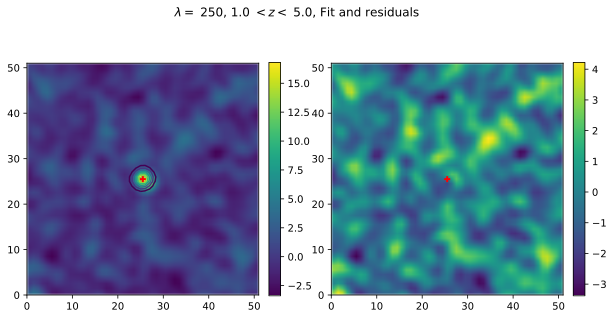

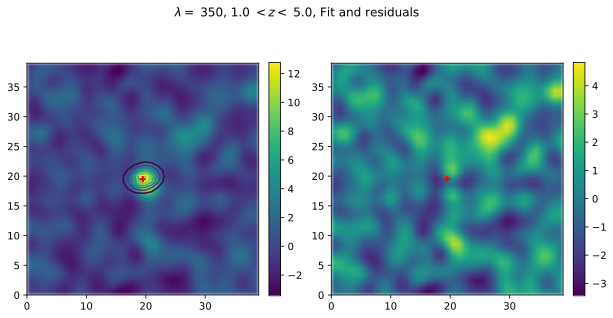

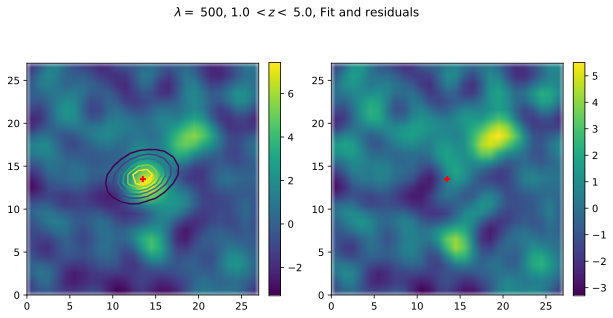

In [4]:
for idz, zbin in enumerate(zbins):
    for lambda_ in lambdas:
            p = anal.GaussFitTot(lambda_, idz, remove_max=0, remove_mean=False, plot=True)
            print lambda_, zbin[0], zbin[1], p.amplitude.value
#             plt.savefig('H-ATLAS_filtered_'+str(lambda_)+'_'+str(zbin[0])+'_'+str(zbin[1])+'.pdf')

In [33]:
for idz, zbin in enumerate(zbins):
    print len(anal.cuts[250]['G9'][idz]) + len(anal.cuts[250]['G12'][idz]) + len(anal.cuts[250]['G15'][idz])

54


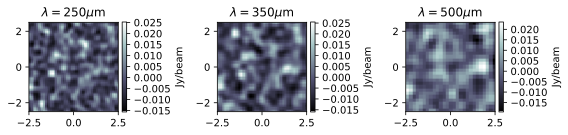

In [101]:
i = 10
patch = 'G15'
plt.figure(figsize=(8,6))
plt.subplot(131)
plt.title(r'$\lambda=250\mu$m')
plt.imshow(anal.cuts[250][patch][0][i],extent=[-2.5,2.5,-2.5,2.5],cmap='bone');plt.colorbar(label='Jy/beam',fraction=0.046, pad=0.04);
plt.subplot(132)
plt.title(r'$\lambda=350\mu$m')
plt.imshow(anal.cuts[350][patch][0][i],extent=[-2.5,2.5,-2.5,2.5],cmap='bone');plt.colorbar(label='Jy/beam',fraction=0.046, pad=0.04);
plt.subplot(133)
plt.title(r'$\lambda=500\mu$m')
plt.imshow(anal.cuts[500][patch][0][i],extent=[-2.5,2.5,-2.5,2.5],cmap='bone');plt.colorbar(label='Jy/beam',fraction=0.046, pad=0.04);
plt.tight_layout()
plt.savefig('/Users/fbianchini/Research/StacktSZ/W4_selected_HotDOG_notsonice.pdf')

In [38]:
anal.extras[250]['G12'][0]['Z']

array([ 2.75214529,  1.26586676,  2.71226907,  2.70440578,  3.03428936,
        1.55327868,  2.08099723,  3.63370228,  1.69880879,  1.33139873,
        1.7177819 ,  1.39525437,  2.60009265,  1.07991934])

In [39]:
from astropy.io import fits

In [49]:
a, h = fits.getdata('/Volumes/LACIE_SHARE/Data/H-ATLAS/G9/HATLAS_GAMA9_DR1_FILT_BACKSUB250.FITS', header=1)

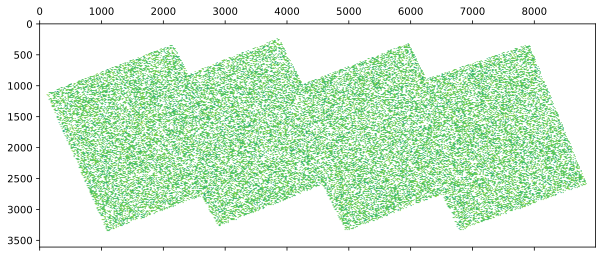

In [82]:
plt.matshow( np.log10(a))

In [105]:
for lam in lambdas:
    print lam, anal.GaussFitTotZ(lam, remove_mean=False).amplitude, anal.GetTotZBootstrapErrsFit2D(lam, remove_mean=False, nsim=300)

250 Parameter('amplitude', value=19.2230602236) 3.99006008225
350 Parameter('amplitude', value=13.580351814) 3.39958827235
500 Parameter('amplitude', value=7.22013963201) 2.03901468276


In [14]:
GetMeIndex(anal.cuts[250]['G9'][0], 250)

array([], dtype=float64)

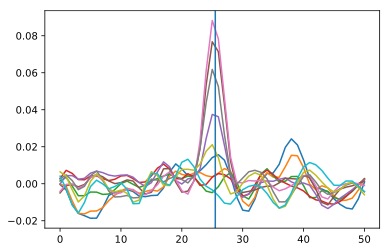

In [205]:
for i in xrange(20,30):
    plt.plot(anal.cuts[250]['G15'][0][2][i,:])
plt.axvline(25.5)

In [57]:
len(AmIReallyResolved(anal, 250, 'G15')) + len(AmIReallyResolved(anal, 250, 'G12')) + len(AmIReallyResolved(anal, 250, 'G9'))

10

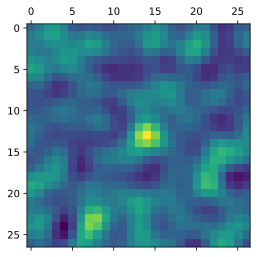

In [56]:
plt.matshow(anal.cuts[500]['G15'][0][2])
# plt.plot(25.5,25.5,'w+',)

In [97]:
HotDOGs_250 = []
HotDOGs_350 = []
HotDOGs_500 = []

for patch in patches:
    HotDOGs_250.append(anal.cuts[250][patch][0][AmIReallyResolved(anal, 250, patch)])
    HotDOGs_350.append(anal.cuts[350][patch][0][AmIReallyResolved(anal, 350, patch)])
    HotDOGs_500.append(anal.cuts[500][patch][0][AmIReallyResolved(anal, 500, patch)])

In [98]:
HotDOGs_250 = np.concatenate(np.asarray(HotDOGs_250), axis=0)
HotDOGs_350 = np.concatenate(np.asarray(HotDOGs_350), axis=0)
HotDOGs_500 = np.concatenate(np.asarray(HotDOGs_500), axis=0)

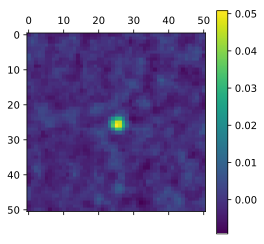

In [96]:

plt.matshow(np.median(HotDOGs, axis=0));plt.colorbar()
# plt.plot(25.5,25.5,'w+',)

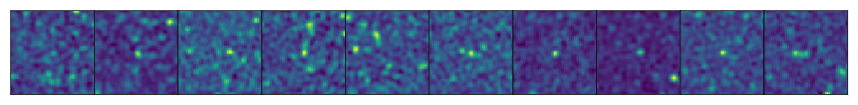

In [130]:
import matplotlib.gridspec as gridspec

fig, axes = plt.subplots(1, 10, figsize=(15,3))
plt.setp(axes, xticks=[], yticks=[])
plt.subplots_adjust(wspace=0, hspace=0)

for i in xrange(HotDOGs.shape[0]):
    axes[i,].imshow(HotDOGs_250[i])
# for i in xrange(HotDOGs.shape[0]):
#     axes[i,1].imshow(HotDOGs_350[i])
# for i in xrange(HotDOGs.shape[0]):
#     axes[i,2].imshow(HotDOGs_500[i])
    
# plt.tight_layout()
plt.savefig('/Users/fbianchini/Research/StacktSZ/HotDOGs_250.pdf', bboxes_inches='tight')